<a href="https://colab.research.google.com/github/VMI1997/UCB-Capstone-Final-Project/blob/main/Final_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Capstone Project**
Matt Linderman

Title:  Model to Predict Bank Customer Attrition

**Introduction:**

**Problem Statement**: The loss of customers is a costly issues for banks that depend on customer deposits to support lending. Further, the cost of acquiring new customers to account for lost customers is very expensive and detrimental to the business of banking. For these reasons, having a model to predict customer attrition is of high importance. Having such a model would allow the bank to proactively target customers at risk of attrition and apply retention techniques to mitigate attrition risk.

**Explanation of Approach**: In this exercise, we are going to leverage readily available data about our existing bank customers - both those that have attrited and those that remain. We are going to use this data to build a number of models with the goal of predicting those customers that are likely to attrite. We will first baseline performance and do a comparative analysis of multiple models to achieve the best results.  We will follow a standard process that follows.

Finally, we will close with our overall findings along with some key next steps from a business standpoint.

**First will load packages required for this exercise.**

In [1]:
#Load key libraries that will be needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

**Data Loading**
Next we load the data from file and inspect the overall characteristics

In [2]:
cust_data = pd.read_csv('attrition_data.csv')
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196906 entries, 0 to 196905
Data columns (total 70 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   application_code                    196906 non-null  object 
 1   opened_month_end_date               196906 non-null  object 
 2   closed_ind                          8619 non-null    float64
 3   closed_month_end_date               8619 non-null    object 
 4   event_month                         196906 non-null  object 
 5   months_open                         196906 non-null  int64  
 6   event_month_branch_number           196905 non-null  float64
 7   event_month_product_code            196905 non-null  object 
 8   event_month_product_description     196905 non-null  object 
 9   event_month_product_category        196905 non-null  object 
 10  prior_month_1_to_event_date         196906 non-null  object 
 11  prior_month_2_to_event_dat

**Data Preparation and Cleansing**

*   Drop fields that will not be needed at all
*   Handle missing values - in this data, a "blank" is an actual zero (there is no need to simulate or create values)
*   Create summary columns and new feaures (using a number of existing data features, we will create some new key features such as "change" over time of the given feature - these are much more meaningful from a business standpoint)
*   Convert boolean values to 0 and 1
*   Handle categorical values (non-numeric) with OneHotEncoding
*   Remove columns no longer needed based on above transformations







In [3]:
#Step 1 - Drop Fields NOT to be used
cust_data_temp = cust_data
cust_data_temp = cust_data_temp.drop(['application_code','opened_month_end_date','closed_month_end_date','event_month_product_code','event_month_product_category','prior_month_1_to_event_date',
                                     'prior_month_2_to_event_date','prior_month_3_to_event_date','prior_month_4_to_event_date','prior_month_5_to_event_date','prior_month_6_to_event_date',
                                     'prior_month_1_interest_rate','prior_month_2_interest_rate','prior_month_3_interest_rate','prior_month_4_interest_rate','prior_month_5_interest_rate',
                                     'prior_month_6_interest_rate','prior_month_2_online_banking_flag','prior_month_3_online_banking_flag','prior_month_4_online_banking_flag',
                                     'prior_month_5_online_banking_flag','prior_month_6_online_banking_flag','prior_month_1_e_statement_flag','prior_month_2_e_statement_flag',
                                     'prior_month_3_e_statement_flag','prior_month_4_e_statement_flag','prior_month_5_e_statement_flag','prior_month_6_e_statement_flag'], axis=1)
#Step 2 - REmediate the NaN values
cust_data_temp.fillna(0, inplace=True)
#cust_data_temp.info()

#Step 3 - Create Summary Columns
cust_data_temp['total_fees'] = (cust_data_temp['prior_month_1_fee_total'] + cust_data_temp['prior_month_2_fee_total'] + cust_data_temp['prior_month_3_fee_total'] +
                                cust_data_temp['prior_month_4_fee_total'] + cust_data_temp['prior_month_5_fee_total'] + cust_data_temp['prior_month_6_fee_total'])
cust_data_temp['total_refunds'] = (cust_data_temp['prior_month_1_fee_refund_total'] + cust_data_temp['prior_month_2_fee_refund_total'] + cust_data_temp['prior_month_3_fee_refund_total'] +
                                cust_data_temp['prior_month_4_fee_refund_total'] + cust_data_temp['prior_month_5_fee_refund_total'] + cust_data_temp['prior_month_6_fee_refund_total'])
cust_data_temp['total_fee_refund_pct'] = cust_data_temp['total_refunds'] / (abs(cust_data_temp['total_fees']) + cust_data_temp['total_refunds'])
cust_data_temp.loc[cust_data_temp['total_fee_refund_pct'].isna(), 'total_fee_refund_pct'] = 0
cust_data_temp['avg_bal_change'] = cust_data_temp['prior_month_6_average_balance'] - cust_data_temp['prior_month_1_average_balance']
cust_data_temp['has_direct_dep'] = 0
cust_data_temp.loc[cust_data_temp['prior_month_1_direct_deposit_total'] > 0, 'has_direct_dep'] = 1
cust_data_temp['ddep_change'] = cust_data_temp['prior_month_6_direct_deposit_total'] - cust_data_temp['prior_month_1_direct_deposit_total']
cust_data_temp['total_od_nsf'] = (cust_data_temp['prior_month_1_od_nsf_items']+cust_data_temp['prior_month_2_od_nsf_items'] + cust_data_temp['prior_month_3_od_nsf_items'] +
                                  cust_data_temp['prior_month_4_od_nsf_items'] + cust_data_temp['prior_month_5_od_nsf_items'] + cust_data_temp['prior_month_6_od_nsf_items'])
cust_data_temp['num_cc_calls'] = (cust_data_temp['prior_month_1_call_center_calls'] + cust_data_temp['prior_month_2_call_center_calls'] + cust_data_temp['prior_month_3_call_center_calls'] +
                                  cust_data_temp['prior_month_4_call_center_calls'] + cust_data_temp['prior_month_5_call_center_calls'] + cust_data_temp['prior_month_6_call_center_calls'])

#Step 4 - Convert boolean to 0 and 1
cust_data_temp['prior_month_1_online_banking_flag'] = cust_data_temp['prior_month_1_online_banking_flag'].map({'Y': 1, 'N': 0})


#Step 5 - Apply One-Hot Encoding
cust_data_temp = pd.get_dummies(cust_data_temp, columns=['event_month_product_description'])
cust_data_temp.head()

#Step 6 - Drop Remaining Columns not used
cust_data_temp.drop(['event_month','event_month_branch_number','prior_month_2_direct_deposit_total','prior_month_3_direct_deposit_total','prior_month_4_direct_deposit_total','prior_month_5_direct_deposit_total',
                     'prior_month_6_direct_deposit_total','prior_month_1_fee_total','prior_month_2_fee_total','prior_month_3_fee_total','prior_month_4_fee_total',
                     'prior_month_5_fee_total','prior_month_6_fee_total','prior_month_1_fee_refund_total','prior_month_2_fee_refund_total','prior_month_3_fee_refund_total',
                     'prior_month_4_fee_refund_total','prior_month_5_fee_refund_total','prior_month_6_fee_refund_total','prior_month_2_average_balance',
                     'prior_month_3_average_balance','prior_month_4_average_balance','prior_month_5_average_balance','prior_month_6_average_balance',
                     'prior_month_1_od_nsf_items','prior_month_2_od_nsf_items','prior_month_3_od_nsf_items','prior_month_4_od_nsf_items','prior_month_5_od_nsf_items',
                     'prior_month_6_od_nsf_items','prior_month_1_call_center_calls','prior_month_2_call_center_calls','prior_month_3_call_center_calls','prior_month_4_call_center_calls',
                     'prior_month_5_call_center_calls','prior_month_6_call_center_calls'],axis=1, inplace=True)

cust_data_temp.fillna(0, inplace=True)
cust_data_temp.head()

,closed_ind,months_open,prior_month_1_direct_deposit_total,prior_month_1_average_balance,prior_month_1_online_banking_flag,total_fees,total_refunds,total_fee_refund_pct,avg_bal_change,has_direct_dep,...,event_month_product_description_PREFERRED MONEY MARKET,event_month_product_description_PRESTIGE 50,event_month_product_description_PRISM CHECKING,event_month_product_description_SOLUTIONS CHECKING,event_month_product_description_SUPER INTEREST CHECKING,event_month_product_description_TEAMMATE CHECKING,event_month_product_description_TEAMMATE MONEY MARKET,event_month_product_description_THANKU CHECKING,event_month_product_description_THE CLUB,event_month_product_description_TRANSITION CHECKING
0,0.0,575,0.0,9886.0,1.0,0.00,0.0,0.0,-1011.0,0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,257,1806.0,2835.0,0.0,0.00,0.0,0.0,-1013.0,1,...,False,False,False,False,False,False,False,False,False,False
2,0.0,18,0.0,3494.0,1.0,0.00,0.0,0.0,83.0,0,...,False,False,False,False,False,False,False,False,False,False
3,0.0,67,0.0,144.0,1.0,-7.15,0.0,0.0,-4.0,0,...,False,False,False,False,False,False,False,False,False,False
4,0.0,54,0.0,524.0,1.0,-0.53,0.0,0.0,748.0,0,...,False,False,False,False,False,False,False,True,False,False


**Data Analysis & Visualization - Examine the overall characteristics of Open/Closed accounts**

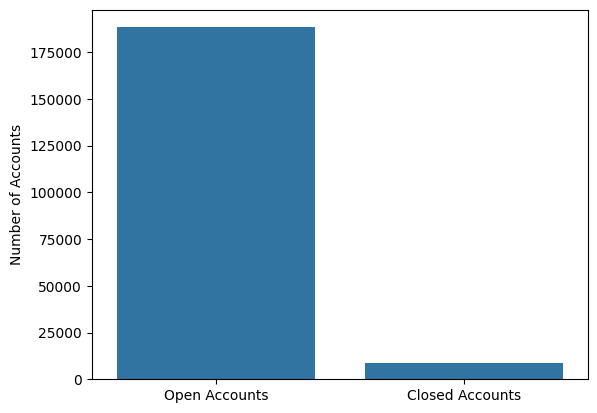

In [4]:
plot = sns.countplot(x='closed_ind', data=cust_data_temp)

# Customize x-axis labels
new_labels = ['Open Accounts','Closed Accounts']
plot.set_xticklabels(new_labels)
plt.xlabel('')
plt.ylabel('Number of Accounts')
plt.show()

**Handle Data Imbalance**

Given the imbalance in the data, we will use SMOTE to create balance through simulated values.

In [6]:
#Address the imbalance issue
cust_data_temp['closed_ind'].value_counts()
X = cust_data_temp.drop('closed_ind', axis=1)
y = cust_data_temp['closed_ind']
smote = SMOTE(random_state=42) # You can set a random state for reproducibility
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts()


,count
closed_ind,
0.0,188287
1.0,188287


**Data Analysis & Visualization - Analyze the Effect of Fees/Refunds on Closure**

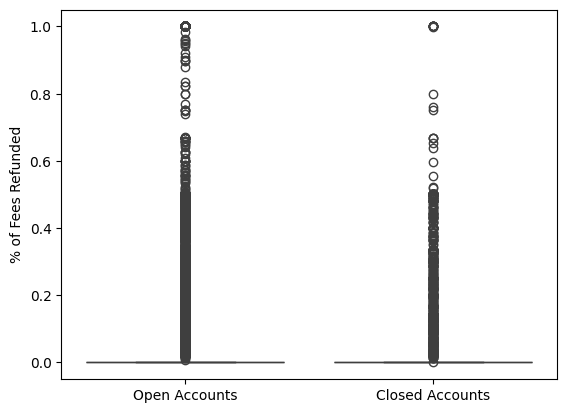

In [6]:
plot = sns.boxplot(x='closed_ind', y='total_fee_refund_pct', data=cust_data_temp)
new_labels = ['Open Accounts','Closed Accounts']
plot.set_xticklabels(new_labels)
plt.ylabel('% of Fees Refunded')
plt.xlabel('')
plt.show()

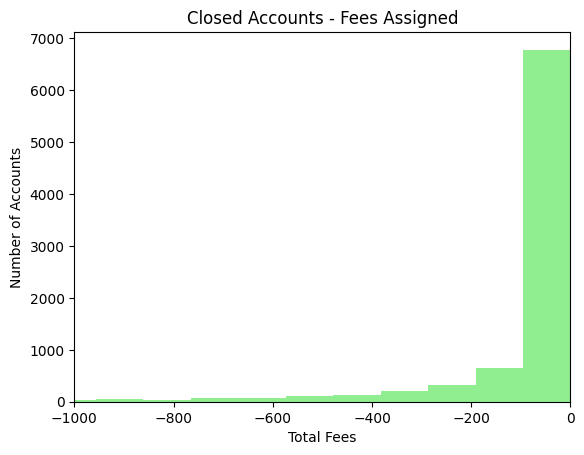

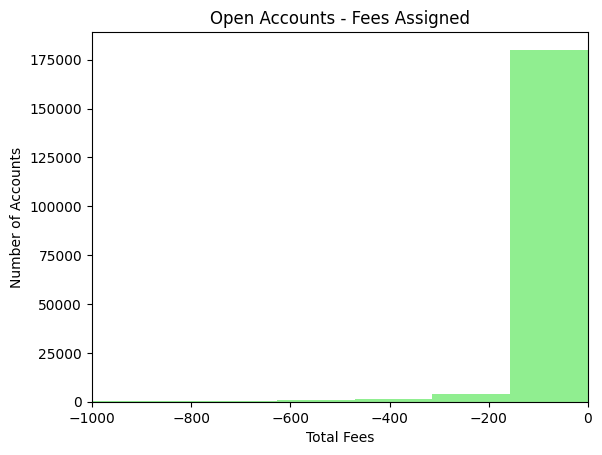

In [7]:
plt.hist(cust_data_temp.query("closed_ind == 1")['total_fees'], color='lightgreen', ec='black', bins=50)
plt.xlim(-1000, 0)
plt.ylabel('Number of Accounts')
plt.xlabel('Total Fees')
plt.title('Closed Accounts - Fees Assigned')
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['total_fees'], color='lightgreen', ec='black', bins=50)
plt.xlim(-1000, 0)
plt.ylabel('Number of Accounts')
plt.xlabel('Total Fees')
plt.title('Open Accounts - Fees Assigned')
plt.show()


**Data Analysis & Visualization - Analyze impact of Tenure on closure**

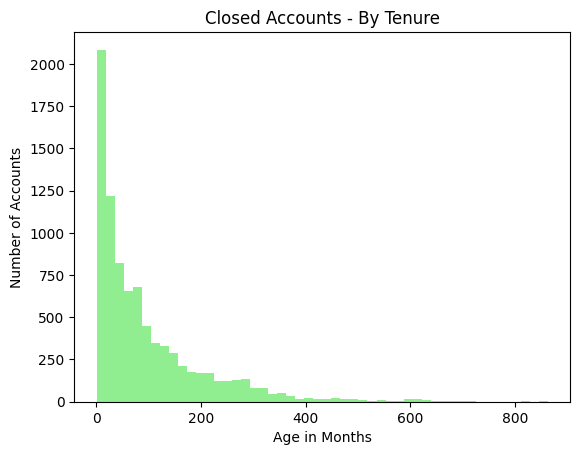

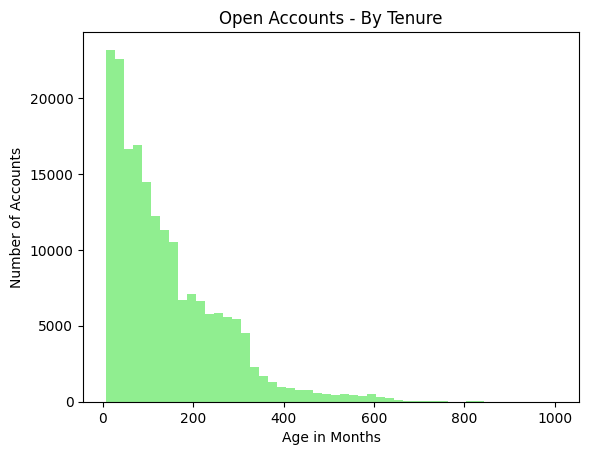

In [8]:
plt.hist(cust_data_temp.query("closed_ind == 1")['months_open'], color='lightgreen', ec='black', bins=50)

plt.ylabel('Number of Accounts')
plt.xlabel('Age in Months')
plt.title('Closed Accounts - By Tenure')
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['months_open'], color='lightgreen', ec='black', bins=50)

plt.ylabel('Number of Accounts')
plt.xlabel('Age in Months')
plt.title('Open Accounts - By Tenure')
plt.show()

**Data Analysis & Visualization - Analyze the impact of Direct Deposit on closure**

This analysis would indicate that customers with DD are substantially less likely to attrite than those without.   This may become a target to increase retention overall.

In [4]:
dd_for_open = cust_data_temp.query("closed_ind == 0")['has_direct_dep'].sum() / len(cust_data_temp.query("closed_ind == 0"))
dd_for_closed = cust_data_temp.query("closed_ind == 1")['has_direct_dep'].sum() / len(cust_data_temp.query("closed_ind == 1"))
print("The % of open accounts with direct deposit is: " + str(dd_for_open))
print("The % of closed accounts with direct deposit is: " + str(dd_for_closed))

The % of open accounts with direct deposit is: 0.6025110602431395
The % of closed accounts with direct deposit is: 0.21568627450980393


**Results:**
*Input here....*

**Data Analysis & Visualization - Analyze Changes in Balance versus Closure**

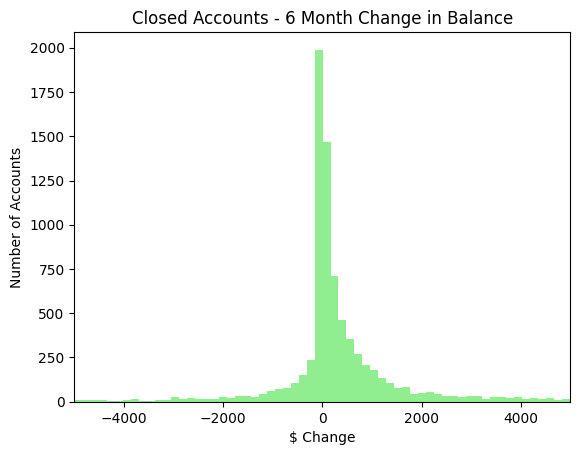

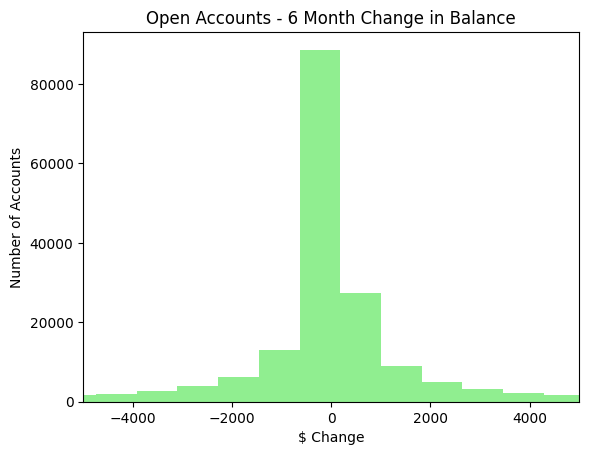

In [10]:
plt.hist(cust_data_temp.query("closed_ind == 1")['avg_bal_change'], color='lightgreen', ec='black', bins=5000)

plt.ylabel('Number of Accounts')
plt.xlabel('$ Change')
plt.title('Closed Accounts - 6 Month Change in Balance')
plt.xlim(-5000, 5000)
plt.show()
plt.hist(cust_data_temp.query("closed_ind == 0")['avg_bal_change'], color='lightgreen', ec='black', bins=5000)
plt.ylabel('Number of Accounts')
plt.xlabel('$ Change')
plt.xlim(-5000, 5000)
plt.title('Open Accounts - 6 Month Change in Balance')
plt.show()

**Data Analysis & Visualization - Examine presence of Online Banking as factor in closure**

In [11]:
ob_for_open = cust_data_temp.query("closed_ind == 0")['prior_month_1_online_banking_flag'].sum() / len(cust_data_temp.query("closed_ind == 0"))
ob_for_closed = cust_data_temp.query("closed_ind == 1")['prior_month_1_online_banking_flag'].sum() / len(cust_data_temp.query("closed_ind == 1"))
print("The % of open accounts with direct deposit is: " + str(ob_for_open))
print("The % of closed accounts with direct deposit is: " + str(ob_for_closed))

The % of open accounts with direct deposit is: 0.7696282802317739
The % of closed accounts with direct deposit is: 0.7850098619329389


**Baseline the Performance**
Let's first look at the baseline performance using DummyClassifier

*   As shown below, the overall accuracy is poor scoring only 50%
*   As we develop our models, we will carefully compare back to this baseline performance





In [7]:
#Baseline the performance
baseline_model = DummyClassifier(strategy='most_frequent')
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Train the model
baseline_model.fit(X_train, y_train)

#Make predictions
y_pred = baseline_model.predict(X_test)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     37714
         1.0       0.50      1.00      0.67     37601

    accuracy                           0.50     75315
   macro avg       0.25      0.50      0.33     75315
weighted avg       0.25      0.50      0.33     75315



**First Model - Logistic Regression**

Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80     37714
         1.0       0.78      0.85      0.81     37601

    accuracy                           0.81     75315
   macro avg       0.81      0.81      0.81     75315
weighted avg       0.81      0.81      0.81     75315



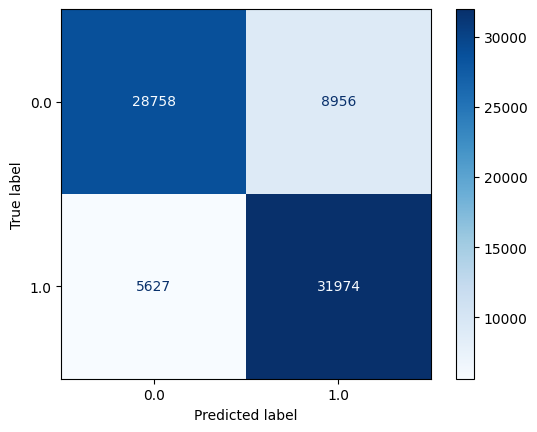

In [8]:
#Logistic Regression Model

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#Look at stratify parameter - stratify=target


#Create Linear Regression Model and Fit
#log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced',C=0.01, penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
#Evaluate the model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**Logistic Regression Summary (initial run):**

*   The logistic regression model performed very efficiently (approx. 6s)
*   The results significantly exceeded the baseline coming in at 81% accuracy.



**Logistic Regression Tuning:**

Next we will leverage RandomizedSearchCV to ensure we have the optimal parameters for this Logistic Regression.

**NOTE:  this takes a LONG time to run**

In [10]:
#Define the grid search criteria
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2500,5000]
}
]

grid_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_
print(best_params)
print(best_lr)

{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'C': np.float64(545.5594781168514)}
LogisticRegression(C=np.float64(545.5594781168514), class_weight='balanced',
                   max_iter=1000, solver='newton-cg')


**First Model (with tuning) - Logistic Regression**

Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80     37714
         1.0       0.78      0.85      0.82     37601

    accuracy                           0.81     75315
   macro avg       0.81      0.81      0.81     75315
weighted avg       0.81      0.81      0.81     75315



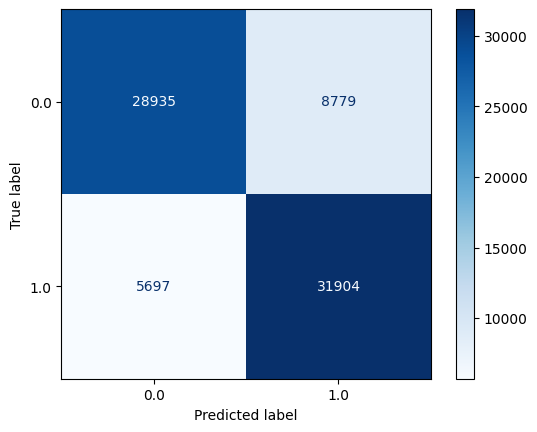

In [11]:
#Logistic Regression Model - Post Tuning

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#Look at stratify parameter - stratify=target


#Create Linear Regression Model and Fit
#log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced',C= np.float64(545.5594781168514), penalty='l2', solver='newton-cg')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
#Evaluate the model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**Logistic Regression Results:**

Tuning provided only very incrementally better performance.   While the overall LR model performs better than baseline, we will continue to evaluate models.

**Second Model - Random Forest Classifier**

0.9395472349465578
Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     37714
         1.0       0.98      0.90      0.94     37601

    accuracy                           0.94     75315
   macro avg       0.94      0.94      0.94     75315
weighted avg       0.94      0.94      0.94     75315



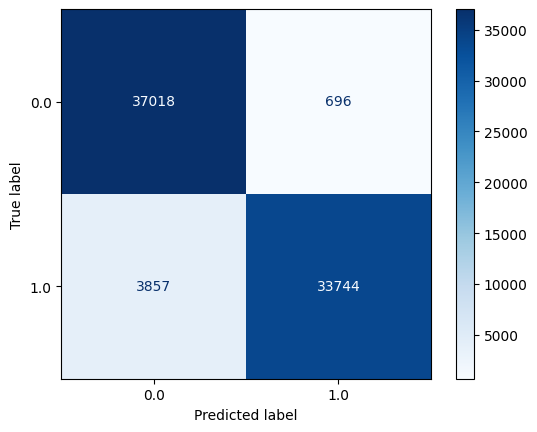

In [14]:
#Random Forest after balancing
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#Look at stratify parameter - stratify=target
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42, class_weight = 'balanced').fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc_score = rf.score(X_test, y_test)
print(acc_score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**Results for Random Forest:**

*   The results of the Random Forest are excellent and far exceed those of the Logistic Regression model
*   An accuracy score of 94% is an exceptional result along with the other key metrics of precision and recall.
*   The performance of this model (training time of approx. 2 minutes versus 6 sec) is substantially longer than logistic regression, but this is acceptable given the use case of a weekly or monthly process




**Random Forest Tuning:**
Next we will leverage GridSearch to ensure we have the optimal parameters for this Random Forest Classifier

**NOTE:  this takes a very LONG time to run!**

In [ ]:
#Random Forest Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Refresh on approach based on feature importance
#X2 = cust_data_temp[['months_open','prior_month_1_direct_deposit_total','prior_month_1_average_balance','total_fees','avg_bal_change','has_direct_dep']]
#y2 = cust_data_temp['closed_ind']

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#Look at stratify parameter - stratify=target
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print(best_params)
print(best_rf)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
RandomForestClassifier(max_depth=15, n_estimators=1000, random_state=42)


**Random Forest Model - Post Tuning**

0.9399190068379473
Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     37714
         1.0       0.98      0.90      0.94     37601

    accuracy                           0.94     75315
   macro avg       0.94      0.94      0.94     75315
weighted avg       0.94      0.94      0.94     75315



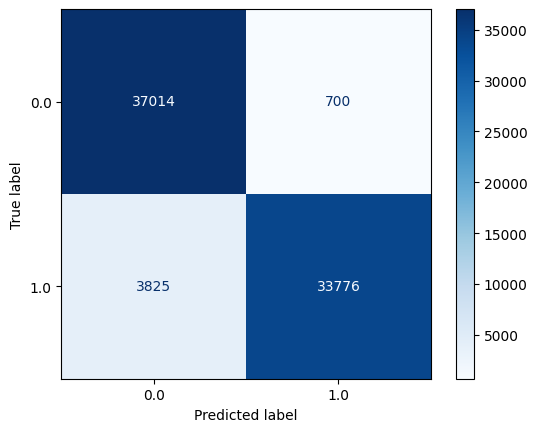

In [15]:
#Random Forest after balancing
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#Look at stratify parameter - stratify=target
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, class_weight = 'balanced', max_features = 'sqrt').fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc_score = rf.score(X_test, y_test)
print(acc_score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**Random Forest - Results Post Tuning**

*   As expected, with the primary change related to increasing number of estimators from 500 to 1000, the training time doubled (still acceptable in a non real-time use case)
*   Accuracy only improved slightly from 93.95 to 93.99%



**Third Model - Gradient Boosting - XGBoost**

0.9579366660027883
Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     37714
         1.0       0.99      0.93      0.96     37601

    accuracy                           0.96     75315
   macro avg       0.96      0.96      0.96     75315
weighted avg       0.96      0.96      0.96     75315



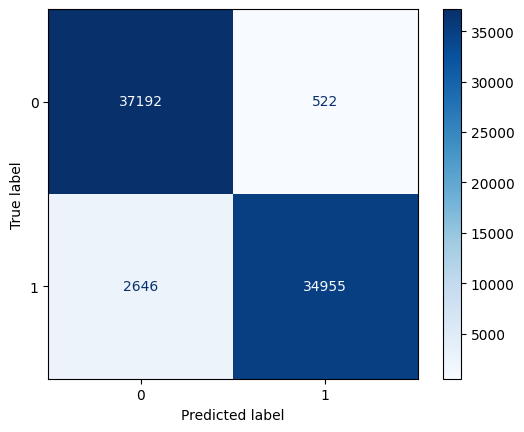

In [16]:
import xgboost as xgb
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an XGBoost classifier
xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Train the classifier
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb.predict(X_test)

acc_score = xgb.score(X_test, y_test)
print(acc_score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**XGBoost Tuning**

**NOTE - this takes a LONG time to run**

In [ ]:
#Tuning for XGBoost
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 10, 100]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 800}
Best score: -0.026487890647368856


**Gradient Boosting - Post Tuning**

0.974480515169621
Baseline Accuracy: {accuracy}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     37714
         1.0       0.98      0.96      0.97     37601

    accuracy                           0.97     75315
   macro avg       0.97      0.97      0.97     75315
weighted avg       0.97      0.97      0.97     75315



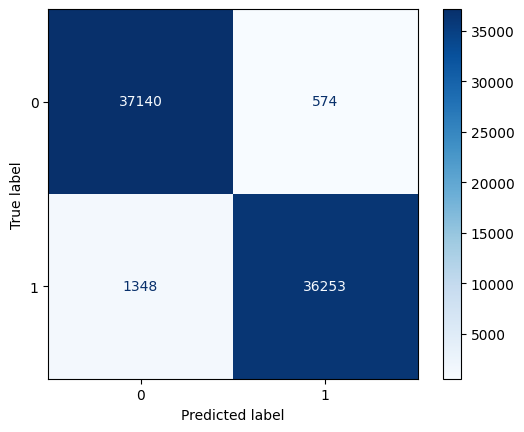

In [17]:
import xgboost as xgb
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an XGBoost classifier
xgb = xgb.XGBClassifier(n_estimators=800, learning_rate = 0.2, max_depth = 9, min_child_weight = 1, random_state=42)

# Train the classifier
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb.predict(X_test)

acc_score = xgb.score(X_test, y_test)
print(acc_score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap='Blues')

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Baseline Accuracy: {accuracy}')
print('Classification Report:')
print(report)

**Gradient Boosting Results:**

These results are excellent and tuning led to even increased performance.   This is a strong model and our recommendation will be for Gradient Boosting.  Knowing this, we will also want to look at what key features drive this model as these will be very important as we think about application of the model.

**Gradient Boosting - Feature Importance Analysis**

Now that we have landed on the Gradient Boosting model, let's analyze the features of highest importance as these will likely be useful in driving actions to mitigate attrition.

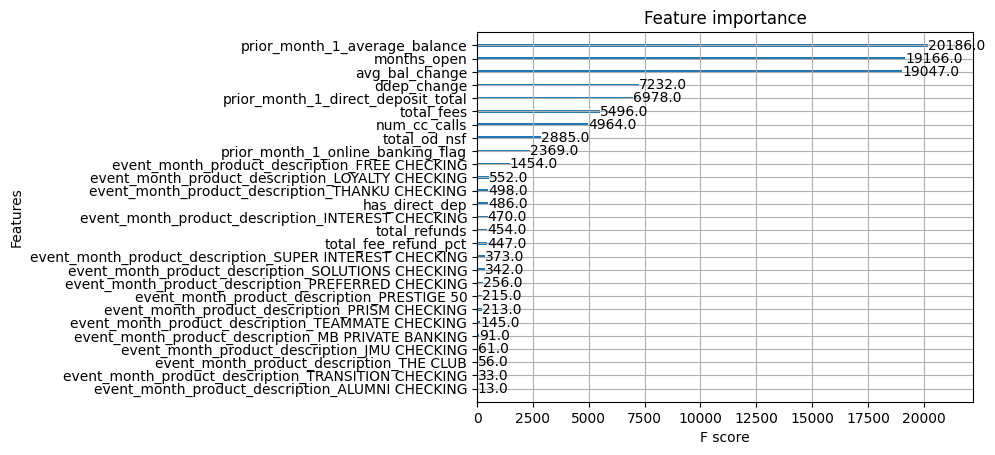

In [18]:
from xgboost import plot_importance

# plot feature importance
plot_importance(xgb)
plt.show()

**What does Feature Importance Tell Us?**

Based on the results above, we believe that the first 5 features are LIKELY to be high indicators of attrtion, BUT are NOT the reason for attrition.  These features are great in support of a proactive outreach to customers (i.e. we noticed that you made X change to Y...). It does appear that OD NSF fees also rank highly and may be a great vector to make proactive waive offers to customers.  This analysis would also indicate that while we have solid data to predict the attrition, we may NOT yet have the data that tells us "why" they are attriting.   Additional data will be sought out to assist with that.


**Final Outcomes and Next Steps:**

Ultimately, we landed on gradient boosting as the optimal model for this classification resulting in strong performance and an accuracy rating of 97%+.   
It is important to note that while this model performs well to identify customers likely to attrite, it does not uncover all of the underlying specific reasons of “why” they are attriting.  This will be a critical consideration in our next steps.
In terms of next steps, we do plan to move this model forward into production at our bank.   We are also planning to work with our business partners to determine the business process that will be wrapped around this model.  This model will drive a proactive outreach to those customers likely to attrite.   As part of that process, the expectation is that the conversations with the customers will seek to uncover the specific reasons they are likely to attrite.  In the future, as we learn more of those, we will consider addition of new data (if available) into the model to help with both identification of the likelihood of attrition AND the reasons for that likely attrition.


*   As mentioned, the ability to predict customer attrition is incredibly important given the need for deposits and the cost of acquisition to replace customers that attrite the bank
*   The following actions could likely be taken using this model:

1.   Execute this model on set period (likely monthly) and identify prediction attritions
2.   Determine which might be "desired" attritions due to profitability, etc.
3.   For desired retention accounts, create target program around a proactive outreach to those customers, with potential offers based on estimated cost of losing
4.  While the individual features may not yield an indication of specific actions, a proactive outreach program to customer likely to attrite will allow us to further gauge drivers of dissastifaction and ultimately closure.



